# Setup

This notebook does layerwise evaluations of large language models using a variety of evaluation metrics.
Authors: Oscar Skean

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
from utils.misc.metric_utils import (
    compute_per_forward_pass,
    compute_on_concatenated_passes,
    compute_entropy,
    compute_lidar,
    compute_dime,
    compute_curvature,
)
from utils.misc.model_dataloader_utils import model_name_to_sizes, get_model_path, get_dataloader, get_augmentation_collated_dataloader

device = "cuda:0"
DISABLE_TQDM = False

# Layerwise Evaluations

In [10]:

def calculate_and_save_layerwise_entropies(model_name, experiment_name, granularity='sentence', alpha=1, normalizations=['maxEntropy'], num_samples=1000):
    assert experiment_name in ['entropy', 'lidar', 'lidar-modified', 'dime', 'curvature']
    assert granularity in ['sentence', 'dataset']

    if 'lidar' in experiment_name or 'dime' in experiment_name:
        assert granularity == 'dataset'
    if 'curvature' in experiment_name:
        assert granularity == 'sentence'

    dataloader_kwargs = {
        "dataset_name": "wikitext",
        "split": "train",
        "num_samples": num_samples,
        "max_sample_length": 512 if model_name == "bert" else 2048,
    }
    dataloader_kwargs.update({'num_augmentations_per_sample': 16} if 'lidar' in experiment_name else {})

    layerwise_entropies_per_model = {}
    for model_size in model_name_to_sizes[model_name]:
        print('\t Computing entropies for model size:', model_size)
        model_path = get_model_path(model_name, model_size)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModel.from_pretrained(model_path, output_hidden_states=True, torch_dtype=torch.bfloat16).to(device)
        
        if granularity == 'sentence':
            dataloader = get_dataloader(tokenizer, **dataloader_kwargs)
            if experiment_name == 'entropy':
                compute_func = lambda hidden_states: compute_entropy(torch.stack(hidden_states), alpha=alpha, normalizations=normalizations)
            elif experiment_name == 'curvature':
                compute_func = lambda hidden_states: compute_curvature(hidden_states, k=1)

            layerwise_entropies_per_model[model_size] = compute_per_forward_pass(model, dataloader, compute_func)

        elif granularity == 'dataset':
            if experiment_name == 'entropy':
                dataloader = get_dataloader(tokenizer, **dataloader_kwargs)
                compute_func = lambda hidden_states: compute_entropy(hidden_states, alpha=alpha, normalizations=normalizations)
            elif 'lidar' in experiment_name:
                dataloader = get_augmentation_collated_dataloader(tokenizer, **dataloader_kwargs)
                compute_func = lambda hidden_states: compute_lidar(hidden_states, alpha=alpha, normalizations=normalizations, return_within_scatter='modified' in experiment_name)
            elif 'dime' in experiment_name:
                dataloader = get_augmentation_collated_dataloader(tokenizer, **dataloader_kwargs)
                compute_func = lambda hidden_states: compute_dime(hidden_states, alpha=alpha, normalizations=normalizations)

            layerwise_entropies_per_model[model_size] = compute_on_concatenated_passes(model, dataloader, compute_func, max_samples=num_samples)

        del model

    for normalization in normalizations:
        with open(f"entropy_results/entropy={experiment_name}_model={model_name}_granularity={granularity}_normalization={normalization}.pkl", "wb") as f:
            pickle.dump({size: results[normalization] for size, results in layerwise_entropies_per_model.items()}, f)

    return layerwise_entropies_per_model

In [3]:
def load_results_layerwise_entropies(model_name, experiment_name, granularity, normalization):
    try:
        with open(f"entropy_results/entropy={experiment_name}_model={model_name}_granularity={granularity}_normalization={normalization}.pkl", "rb") as f:
            layerwise_entropies_per_model = pickle.load(f)
        return layerwise_entropies_per_model
    except FileNotFoundError:
        return None

In [15]:
models = ['bert']
experiments = ['curvature', 'lidar', 'entropy']
granularities = ['sentence', 'dataset']
normalizations = ['maxEntropy', 'raw', 'logN', 'logNlogD', 'logD']

for model in models:
    for experiment in experiments:
        for granularity in granularities:
            try:
                print(f"\nRunning: {model}, {experiment}, {granularity}")

                current_normalizations = ['raw'] if 'curvature' in experiment else normalizations

                all_computed = True
                for normalization in current_normalizations:
                    results = load_results_layerwise_entropies(model, experiment, granularity, normalization)
                    if results is None:
                        all_computed = False
                        break

                if not all_computed:
                    print(f"\tComputing all normalizations for: {model}, {experiment}, {granularity}")
                    calculate_and_save_layerwise_entropies(model, experiment, granularity, alpha=1, normalizations=current_normalizations, num_samples=1000)
                else:
                    print(f"\tAll normalizations already computed, skipping: {model}, {experiment}, {granularity}")
            except AssertionError as e:
                print(f"\tAssertionError for {model}, {experiment}, {granularity}: {str(e)}")
            except Exception as e:
                print(f"\tError for {model}, {experiment}, {granularity}: {str(e)}")
                raise e


Running: bert, curvature, sentence
	All normalizations already computed, skipping: bert, curvature, sentence

Running: bert, curvature, dataset
	Computing all normalizations for: bert, curvature, dataset
	AssertionError for bert, curvature, dataset: 

Running: bert, lidar, sentence
	Computing all normalizations for: bert, lidar, sentence
	AssertionError for bert, lidar, sentence: 

Running: bert, lidar, dataset
	All normalizations already computed, skipping: bert, lidar, dataset

Running: bert, entropy, sentence
	All normalizations already computed, skipping: bert, entropy, sentence

Running: bert, entropy, dataset
	Computing all normalizations for: bert, entropy, dataset
	 Computing entropies for model size: base


 40%|████      | 4/10 [00:00<00:00,  6.47it/s]


torch.Size([13, 4, 768])
	 Computing entropies for model size: large


 40%|████      | 4/10 [00:00<00:01,  5.52it/s]

torch.Size([25, 4, 1024])


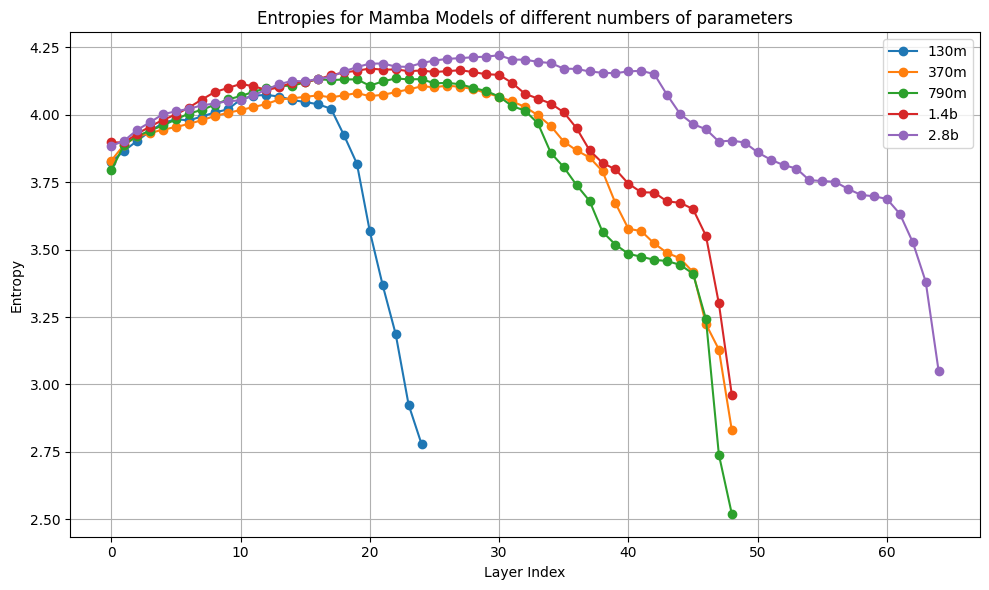

In [ ]:
import matplotlib.pyplot as plt

layerwise_entropies = load_results_layerwise_entropies("mamba", 'alpha1', granularity='sentence', normalization='raw')

fig, ax = plt.subplots(figsize=(10, 6))

for model_name, entropies in layerwise_entropies.items():
    ax.plot(entropies, marker='o', label=model_name)

ax.set_title('Entropies for Mamba Models of different numbers of parameters')
ax.set_xlabel('Layer Index')
ax.set_ylabel('Entropy')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

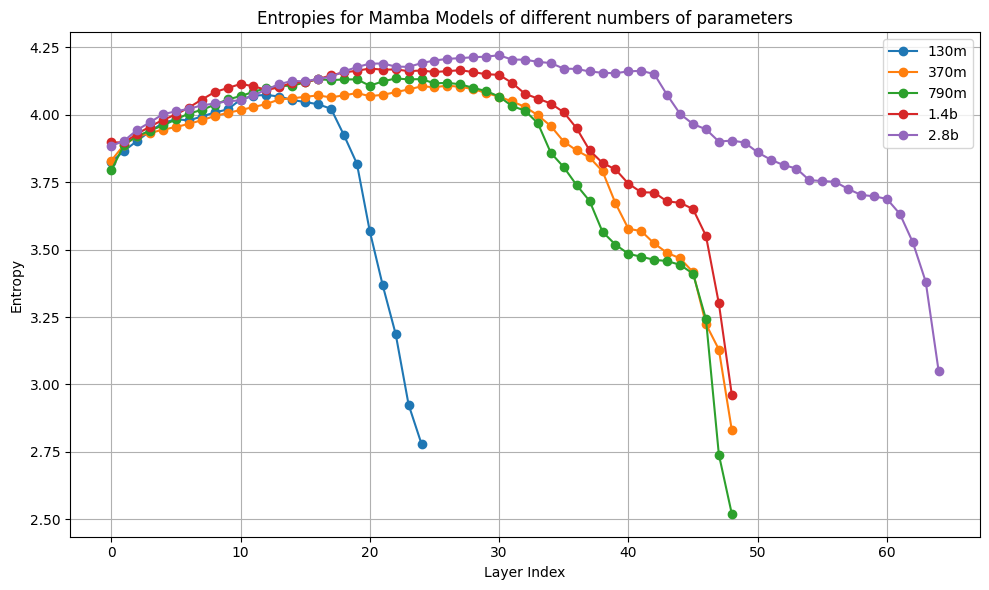

In [ ]:
import matplotlib.pyplot as plt

layerwise_entropies = load_results_layerwise_entropies("mamba", 'alpha1', granularity='sentence', normalization='raw')

fig, ax = plt.subplots(figsize=(10, 6))

for model_name, entropies in layerwise_entropies.items():
    ax.plot(entropies, marker='o', label=model_name)

ax.set_title('Entropies for Mamba Models of different numbers of parameters')
ax.set_xlabel('Layer Index')
ax.set_ylabel('Entropy')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

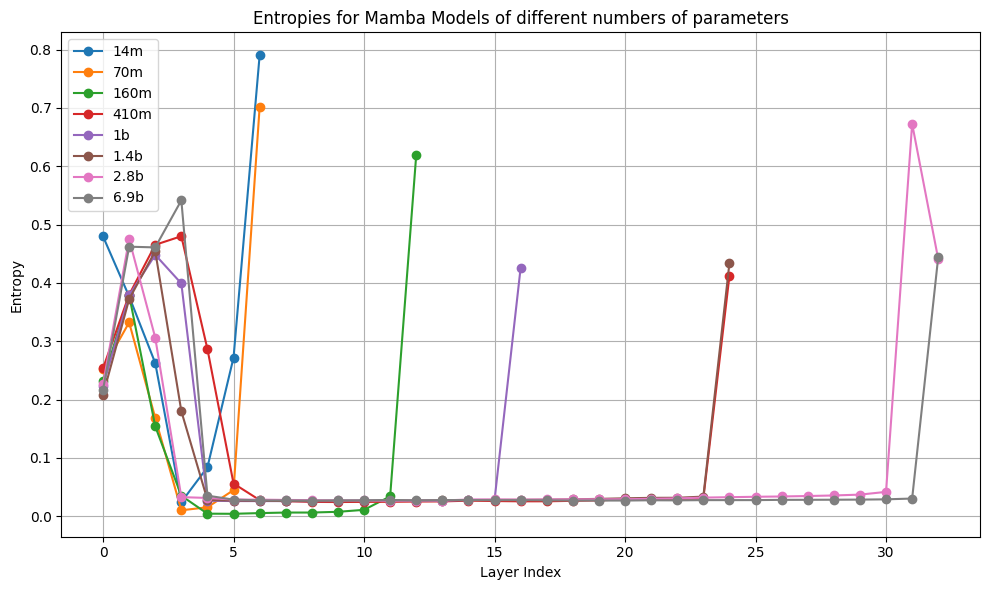

In [ ]:
import matplotlib.pyplot as plt

layerwise_entropies = load_results_layerwise_entropies("EleutherAI", 'alpha1', granularity='dataset', normalization='maxEntropy')

fig, ax = plt.subplots(figsize=(10, 6))

for model_name, entropies in layerwise_entropies.items():
    ax.plot(entropies, marker='o', label=model_name)

ax.set_title('Entropies for Mamba Models of different numbers of parameters')
ax.set_xlabel('Layer Index')
ax.set_ylabel('Entropy')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with a subplot for each model
num_models = len(layerwise_entropies_per_model)
fig, axs = plt.subplots(num_models, 1, figsize=(8, 3 * num_models), sharex=True)

all_entropies = [entropy for entropies in layerwise_entropies_per_model.values() for entropy in entropies]
y_min, y_max = min(all_entropies), max(all_entropies)

# Flatten axs if there is only one subplot
if num_models == 1:
    axs = [axs]

# Plot each model's data
for ax, (model_name, entropies) in zip(axs, layerwise_entropies_per_model.items()):
    ax.plot(entropies, marker='o')
    ax.set_title(f'Entropies for {model_name}')
    ax.set_ylabel('Entropy')
    ax.set_ylim(y_min*0.95, y_max*1.05)
    ax.grid(True)

# Set common x-axis label
axs[-1].set_xlabel('Layer Index')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'layerwise_entropies_per_model' is not defined

## Data Augmentation

In [1]:
from utils import text_augmentation

input_text = ["The quick brown fox jumps over the lazy dog."]

augmented_text = text_augmentation(input_text, num_augmentations_per_sample=10)
print(f"Original text: {input_text}")
for i, t in enumerate(augmented_text[0].split(',')):
    print(f"Augmented text {i}: {t}")

Original text: ['The quick brown fox jumps over the lazy dog.']
Augmented text 0: ['The q 8ecU b rfBg fox j uHem oSe! the lQz5 dog.'
Augmented text 1:  'The qu ick b Co#p fox P*mks o ver the gFzH dog.'
Augmented text 2:  'The qGiBI HUo3n fox jum ps o ver the la zy dog.'
Augmented text 3:  'The q uJ)Q bro wn fox ju mps oF2$ the l1x0 dog.'
Augmented text 4:  'The q&Jfk b r + wz fox jum ps o ver the lSay dog.'
Augmented text 5:  'The q V&cd br own fox jum ps Xve # the & az (dog.'
Augmented text 6:  'The qu ick bAoQS fox jum ps * vea the la zy dog.'
Augmented text 7:  'The qu ick b & 2wn fox jxbpx dcwr the la zy dog.'
Augmented text 8:  'The q u @ zk b # dwn fox j f<pd ov er the T0ay dog.'
Augmented text 9:  'The !uZXf bro wn fox jum ps M7eF the l azy dog.']


# Plotting

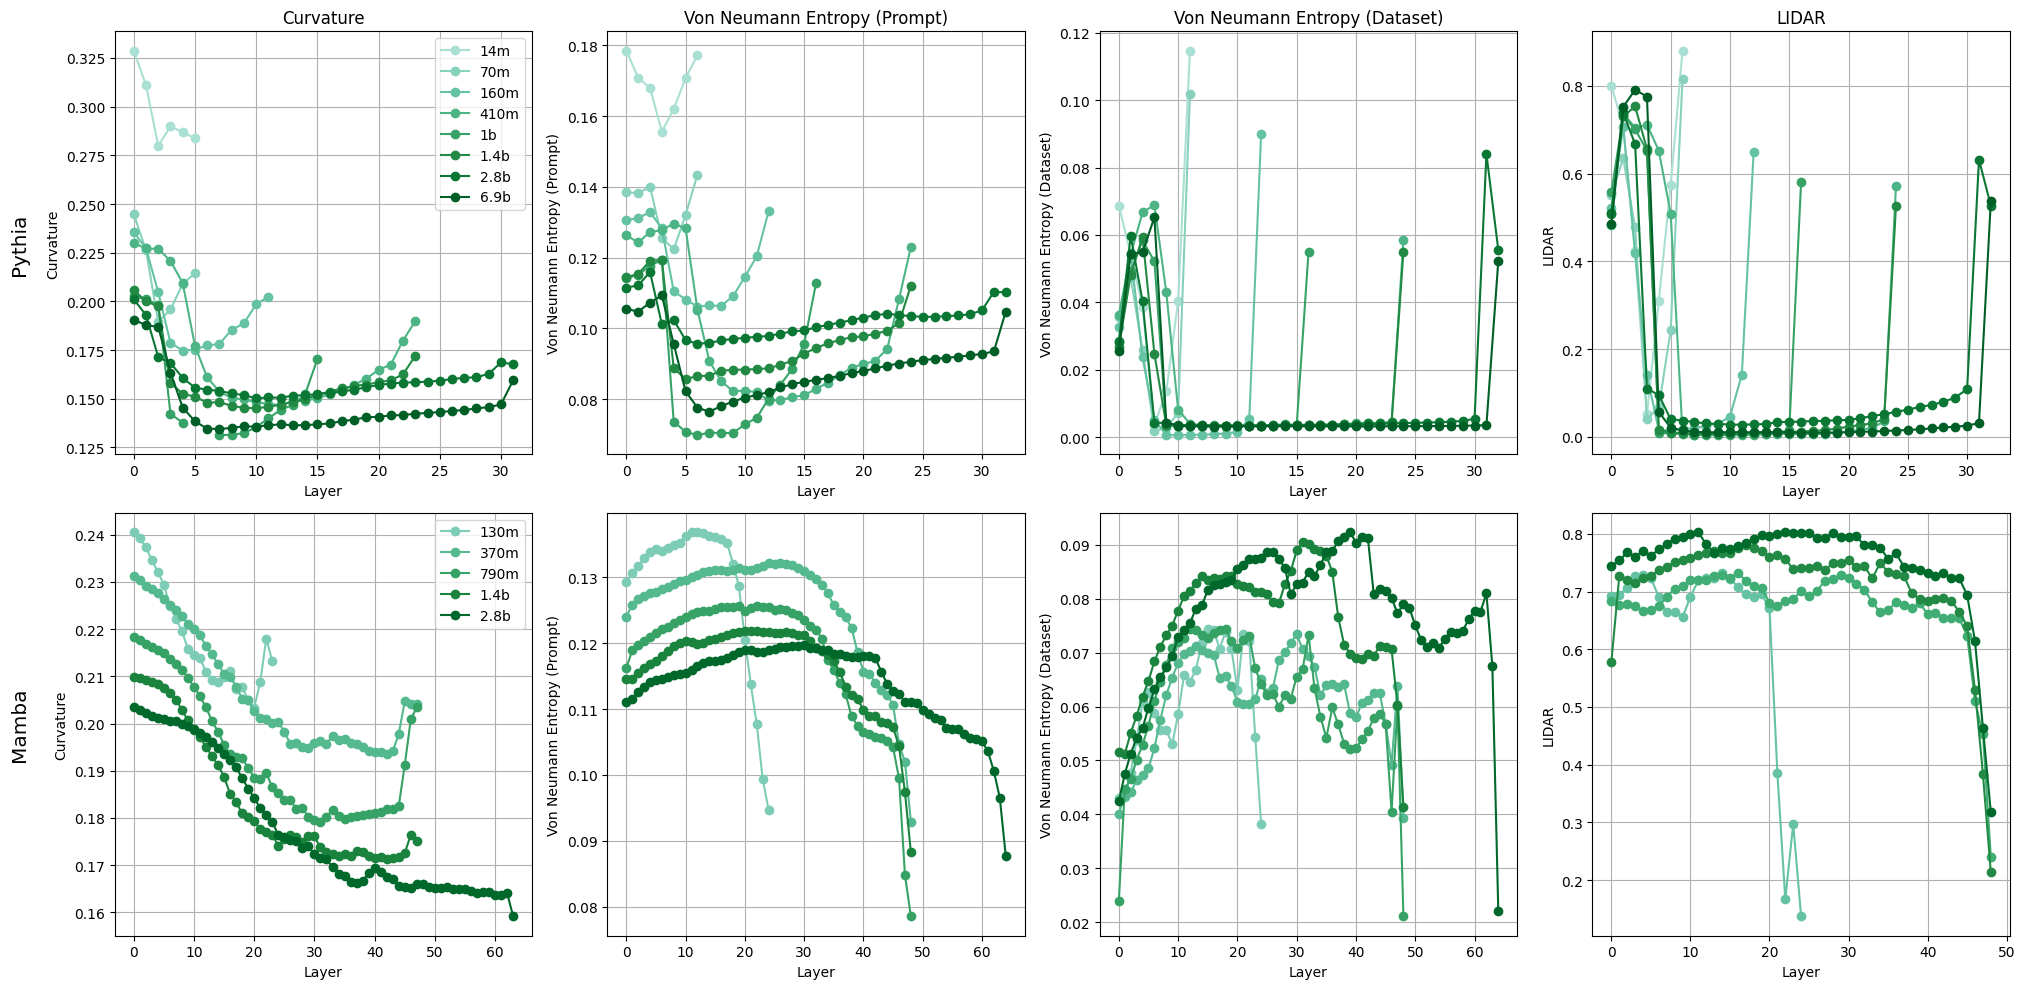

In [21]:
import matplotlib.pyplot as plt
import pickle

def load_results_layerwise_entropies(model_name, experiment_name, granularity, normalization):
    with open(f"entropy_results/entropy={experiment_name}_model={model_name}_granularity={granularity}_normalization={normalization}.pkl", "rb") as f:
        layerwise_entropies_per_model = pickle.load(f)
    return layerwise_entropies_per_model

models = ["EleutherAI", "mamba"] 
experiments = ["curvature", "alpha1", "alpha1","lidar"]

# Create the grid of subplots
A = len(models)
B = len(experiments)
fig, axs = plt.subplots(A, B, figsize=(5 * B, 5 * A))

# Create row and column labels
row_labels = ['Pythia', 'Mamba']
col_labels = ['Curvature', 'Von Neumann Entropy (Prompt)', 'Von Neumann Entropy (Dataset)', 'LIDAR']

# Iterate over models and experiments
for i, model_name in enumerate(models):
    for j, experiment_name in enumerate(experiments):
        # Load entropies for each model and experiment
        granularity = 'sentence' if 'alpha1' in experiment_name and j==1 else 'dataset'
        granularity = 'sentence' if 'curvature' in experiment_name else granularity

        normalization = 'logNlogD'
        normalization = 'raw' if 'curvature' in experiment_name else normalization
        normalization = 'maxEntropy' if 'lidar' in experiment_name else normalization

        try:
            layerwise_entropies = load_results_layerwise_entropies(model_name, experiment_name, granularity=granularity, normalization=normalization)
        except FileNotFoundError as e:
            print(e)
            layerwise_entropies=None

        # Access the corresponding subplot
        ax = axs[i, j] if A > 1 and B > 1 else axs[j] if A == 1 else axs[i]

        if layerwise_entropies is not None:
            for model_size_idx, (model_variant, entropies) in enumerate(layerwise_entropies.items()):
                offset = 4
                color = plt.cm.BuGn( (model_size_idx+offset) / (len(layerwise_entropies) + offset) )
                ax.plot(entropies, marker='o', label=model_variant, color=color)
        else:
            ax.text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')

        # Set the labels
        ax.set_xlabel('Layer')
        ax.set_ylabel(f'{col_labels[j]}')
        if i==0:
            ax.set_title(f'{col_labels[j]}')
        
        if j == 0:
            ax.legend()
        ax.grid(True)
# Set row labels using ax.text
for i, row in enumerate(row_labels):
    y_position = (A-i-0.5)/A
    if i == 1:
        y_position += 0.02  # Adjust this value to fine-tune the position
    fig.text(-0.001, y_position, row, rotation=90, va='center', ha='right', fontsize='x-large')

# Adjust layout
plt.tight_layout()
plt.show()

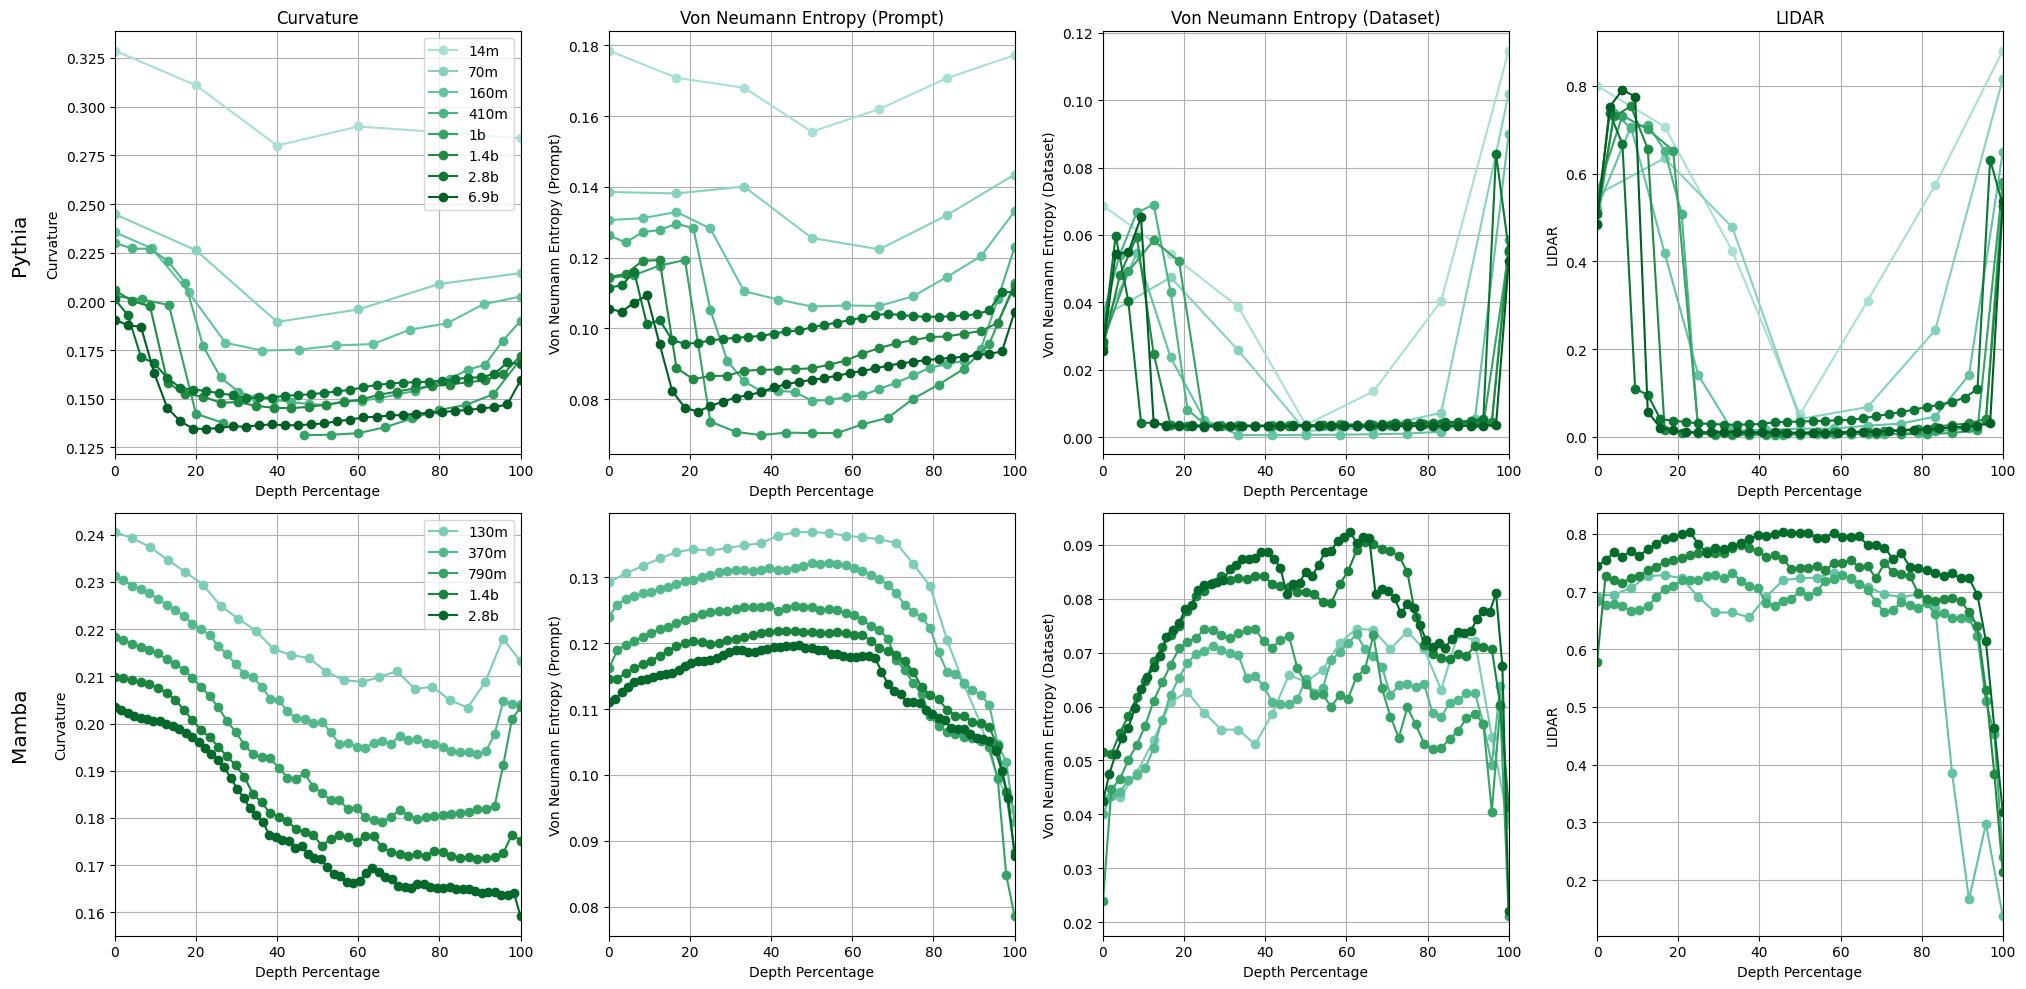

In [20]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

def load_results_layerwise_entropies(model_name, experiment_name, granularity, normalization):
    with open(f"entropy_results/entropy={experiment_name}_model={model_name}_granularity={granularity}_normalization={normalization}.pkl", "rb") as f:
        layerwise_entropies_per_model = pickle.load(f)
    return layerwise_entropies_per_model

models = ["EleutherAI", "mamba"] 
experiments = ["curvature", "alpha1", "alpha1","lidar"]

# Create the grid of subplots
A = len(models)
B = len(experiments)
fig, axs = plt.subplots(A, B, figsize=(5 * B, 5 * A))

# Create row and column labels
row_labels = ['Pythia', 'Mamba']
col_labels = ['Curvature', 'Von Neumann Entropy (Prompt)', 'Von Neumann Entropy (Dataset)', 'LIDAR']

# Iterate over models and experiments
for i, model_name in enumerate(models):
    for j, experiment_name in enumerate(experiments):
        # Load entropies for each model and experiment
        granularity = 'sentence' if 'alpha1' in experiment_name and j==1 else 'dataset'
        granularity = 'sentence' if 'curvature' in experiment_name else granularity

        normalization = 'logNlogD'
        normalization = 'raw' if 'curvature' in experiment_name else normalization
        normalization = 'maxEntropy' if 'lidar' in experiment_name else normalization

        try:
            layerwise_entropies = load_results_layerwise_entropies(model_name, experiment_name, granularity=granularity, normalization=normalization)
        except FileNotFoundError as e:
            print(e)
            layerwise_entropies=None

        # Access the corresponding subplot
        ax = axs[i, j] if A > 1 and B > 1 else axs[j] if A == 1 else axs[i]

        if layerwise_entropies is not None:
            for model_size_idx, (model_variant, entropies) in enumerate(layerwise_entropies.items()):
                offset = 4
                color = plt.cm.BuGn( (model_size_idx+offset) / (len(layerwise_entropies) + offset) )
                depth_percentage = np.linspace(0, 100, len(entropies))
                ax.plot(depth_percentage, entropies, marker='o', label=model_variant, color=color)
        else:
            ax.text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')

        # Set the labels
        ax.set_xlabel('Depth Percentage')
        ax.set_ylabel(f'{col_labels[j]}')
        if i==0:
            ax.set_title(f'{col_labels[j]}')
        
        if j == 0:
            ax.legend()
        ax.grid(True)
        ax.set_xlim(0, 100)
# Set row labels using ax.text
for i, row in enumerate(row_labels):
    y_position = (A-i-0.5)/A
    if i == 1:
        y_position += 0.02  # Adjust this value to fine-tune the position
    fig.text(-0.001, y_position, row, rotation=90, va='center', ha='right', fontsize='x-large')

# Adjust layout
plt.tight_layout()
plt.show()